# LayerNorm from Scratch

In this notebook I want to dive into using and visualizing the LayerNorm implementation that I wrote. Just like what I did with BatchNorm, I want to
- compare it to PyTorch’s implementation
- visualize its effect on feature distributions

First, I'm going to manually fix the path so that we run all the code from the root of the repository.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # layernorm/ is up one level

Now we can setup with our imports.

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from layernorm.layers import LayerNorm

I wrote a test suite before I started implementing LayerNorm for good practice. I usually run the tests in the command line but I'm going to use the python workaround for that.

In [5]:
import subprocess
import os

os.chdir("../tests")

result = subprocess.run(["pytest", "test_layernorm.py"], capture_output=True, text=True)

print(result.stdout)
print(result.stderr)

result = subprocess.run(["pytest", "test_utils.py"], capture_output=True, text=True)

print(result.stdout)
print(result.stderr)

============================= test session starts ==============================
platform darwin -- Python 3.13.2, pytest-8.4.1, pluggy-1.6.0
rootdir: /Users/akhilvreddy/Documents/layernorm-reimplementation
configfile: pytest.ini
collected 3 items

test_layernorm.py ...                                                    [100%]

============================== 3 passed in 0.48s ===============================


============================= test session starts ==============================
platform darwin -- Python 3.13.2, pytest-8.4.1, pluggy-1.6.0
rootdir: /Users/akhilvreddy/Documents/layernorm-reimplementation
configfile: pytest.ini
collected 2 items

test_utils.py ..                                                         [100%]

============================== 2 passed in 0.47s ===============================




Okay, so that's promising. First, our utils functions passing means that it is computing the mean and variance across a feature properly. 

Next, our layernorm functions passing means that our tensor shapes are sturdy after the forward pass. 

We can start by generating some toy data.

In [6]:
# a batch of 5 samples, 8 features each
x = torch.randn(5, 8) * 10 + 100  # shifted and scaled input
print("Original Input:\n", x)

Original Input:
 tensor([[107.6872,  99.1163,  90.2720, 102.4923,  95.7474,  92.1404,  85.0846,
          85.1257],
        [126.0147, 106.7205,  92.8220, 106.6591,  96.4033, 114.6898,  87.7042,
         112.8512],
        [ 85.0728, 111.1094, 114.9505,  97.9527, 100.2561, 104.7603, 102.4607,
          93.9358],
        [108.0406,  95.2615,  83.1148,  94.8324, 114.3759,  91.4483,  84.5752,
          88.2803],
        [122.3765, 104.8232, 105.6186,  99.4626, 105.7946,  97.1177,  99.1660,
         100.9181]])


As we can see, our input feature values are huge. I set it up like this (centered around 100, deviation of 10) on purpose so that the effects of LayerNorm will be very pronounced.

Let's compare this to PyTorch's native implementation first.

In [9]:
my_ln = LayerNorm(8)
torch_ln = nn.LayerNorm(8)

# match weights for fair comparison
torch_ln.weight.data = my_ln.gamma.data.clone()
torch_ln.bias.data = my_ln.beta.data.clone()

out_my = my_ln(x)
out_torch = torch_ln(x)

print("My LayerNorm Output:\n", out_my)
print("PyTorch LayerNorm Output:\n", out_torch)

print("Difference:", torch.abs(out_my - out_torch).max())

My LayerNorm Output:
 tensor([[ 1.7111,  0.5812, -0.5849,  1.0262,  0.1370, -0.3385, -1.2688, -1.2633],
        [ 1.7334,  0.1045, -1.0689,  0.0993, -0.7666,  0.7773, -1.5010,  0.6221],
        [-1.8362,  1.1078,  1.5421, -0.3799, -0.1194,  0.3899,  0.1298, -0.8341],
        [ 1.2635,  0.0262, -1.1500, -0.0154,  1.8770, -0.3430, -1.0085, -0.6498],
        [ 2.4126,  0.0555,  0.1623, -0.6643,  0.1860, -0.9791, -0.7041, -0.4688]],
       grad_fn=<AddBackward0>)
PyTorch LayerNorm Output:
 tensor([[ 1.7111,  0.5812, -0.5849,  1.0262,  0.1370, -0.3385, -1.2688, -1.2633],
        [ 1.7334,  0.1045, -1.0689,  0.0993, -0.7666,  0.7773, -1.5010,  0.6221],
        [-1.8362,  1.1078,  1.5421, -0.3799, -0.1194,  0.3899,  0.1298, -0.8341],
        [ 1.2635,  0.0262, -1.1500, -0.0154,  1.8770, -0.3430, -1.0085, -0.6498],
        [ 2.4126,  0.0555,  0.1623, -0.6643,  0.1860, -0.9791, -0.7041, -0.4688]],
       grad_fn=<NativeLayerNormBackward0>)
Difference: tensor(2.3842e-07, grad_fn=<MaxBackward1>)


In [10]:
print(torch.allclose(out_my, out_torch, atol=1e-5))

True


That tells us that our implementation is within 0.00001 of PyTorch's native implementation (2.3842e-07 to be exact). 

Next, for all 8 features, I want to show how much they've moved after layernorm.

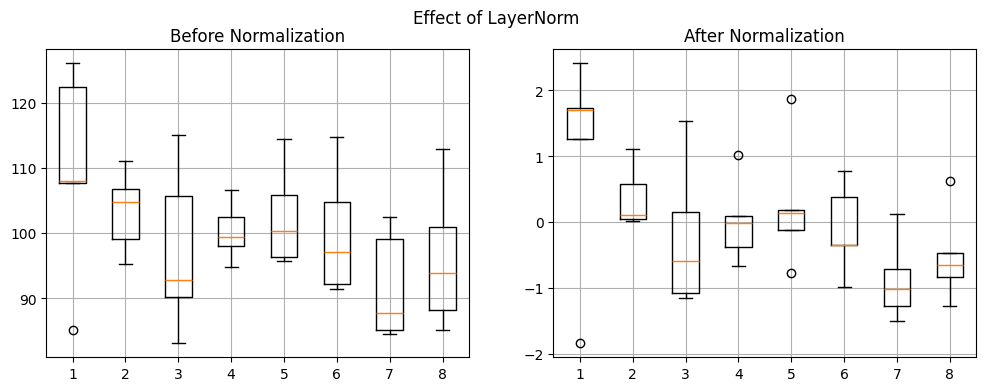

In [11]:
def plot_feature_distributions(x_before, x_after, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Before Normalization")
    plt.boxplot(x_before.detach().numpy())
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title("After Normalization")
    plt.boxplot(x_after.detach().numpy())
    plt.grid()

    plt.suptitle(title)
    plt.show()

plot_feature_distributions(x, out_my, title="Effect of LayerNorm")

That's also promising. The distribution looks similar-ish but now the mean is centerd around 0 and variance is much lower. This is probably the most we want to push normalization.

So we see that our LayerNorm implementation is definitely working *per feature*. I want to see it in action next.

I'll' wrap up by training a simple MLP twice: with and without LayerNorm.

First, I'll create some dummy data.

In [12]:
x = torch.randn(128, 16)
true_w = torch.randn(16, 1)
y = x @ true_w + torch.randn(128, 1) * 0.1

And then I'm going to create two independent classes.

In [13]:
class MLPWithLN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16, 16)
        self.ln = LayerNorm(16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(self.ln(x))
        return self.fc2(x)

In [14]:
class MLPWithoutLN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        return self.fc2(x)

Since we are doing a model sweep:

In [15]:
models = {
    "With LayerNorm": MLPWithLN(),
    "Without LayerNorm": MLPWithoutLN()
}

I'll run the training loop.

In [16]:
loss_fn = nn.MSELoss()
histories = {}

for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    losses = []
    for epoch in range(100):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    histories[name] = losses

I didn't add any logging metrics but let's take a look at the loss curves.

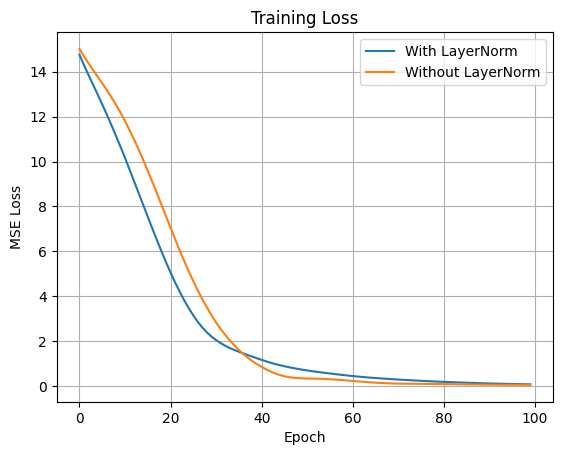

In [17]:
for name, losses in histories.items():
    plt.plot(losses, label=name)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()

We can see that we have an improvement, nothing *huge* but still it's pretty visible that LayerNorm is helping. The real benefit is in real world situations when our data is even noisier than the toy data I generated and we have many layers stacked (like in transformers).